# DEFINE GOOGLE COLAB FLAG!

In [6]:
isGoogleColab = False

# Notes

- check these blog posts: https://muellerzr.github.io/fastblog/ and his course: https://walkwithfastai.com/intro.contribute
- learner.export() already save all the transforms that will be applied during inference time, so it is not necessary to resize or normalize stats. If running outside the model outside fastai, check: https://forums.fast.ai/t/do-we-need-to-normalize-single-image-before-running-predict-function-on-it/44301/4
- to_fp16() is mixed precision
- item_tfms already apply the resize before collating the images in a batch. So it is not necessary to do this manually
- aug_tfms will only be applied on train_dl. validation and test will not be affected
- test_dl is a testing dataloader that uses the same transforms as train_dl and valid_dl, but with new data
- use fastinference library to evaluate and get predictions easier, already decoded
- check images cleaner in the future
- cross validation: check walkwithfastai video 3 or https://forums.fast.ai/t/is-it-possible-to-implement-cross-validation-in-fastai/44961/15



# Installation

## Kill all other GPU sessions

Run the first time this cell. Then, restart your session and run again the notebook without this code.

In [7]:
  #!kill -9 -1

## Update ipython/ipykernel (Colab)

The Colab session can fail when running the first time this cell. Just run it a second time.

In [8]:
# This magic cell should be put first in your colab notebook. 
# It'll automatically upgrade colab's really antique ipython/ipykernel to their 
# latest versions which are required for packages like ipyexperiments 
from packaging import version
import IPython, ipykernel
IPython.__version__
if version.parse(IPython.__version__) <= version.parse("5.5.0"):
    !pip install -q --upgrade ipython
    !pip install -q --upgrade ipykernel
    
    import os
    import signal
    os.kill(os.getpid(), signal.SIGTERM)
print(f"ipykernel=={ipykernel.__version__}")
print(f"IPython=={IPython.__version__}")

ipykernel==5.3.4
IPython==7.21.0


In [9]:
# new (large)
# !pip install ipyexperiments
# new (large)
# from ipyexperiments import IPyExperimentsPytorch
# exp = IPyExperimentsPytorch()

## Check GPU e CPU RAM

In [10]:
if isGoogleColab:
    
    import torch
    from pynvml import *
    nvmlInit()
    def log_mem():
        h = nvmlDeviceGetHandleByIndex(0)
        info = nvmlDeviceGetMemoryInfo(h)
        print(f'GPU total Memory    : {info.total}')
        print(f'GPU free Memory     : {info.free}')
        print(f'GPU Memory used     : {info.used}')
    torch.ones(1).to(0)
    log_mem()

## Mount the Google Drive to Google Colab

In [11]:
if isGoogleColab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    path_to_drive = "/content/drive/My Drive/Colab Notebooks/"
else:
    path_to_drive = "./"

## Install Deep Learning libraries

In [12]:
#  !pip uninstall fastai
#  !pip install fastai
#  !pip install wandb
#  !pip install fastinference

In [13]:
import sys; print('Python:',sys.version)
import torch; print('Pytorch:',torch.__version__)
import fastai; print('Fastai:',fastai.__version__)

Python: 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
Pytorch: 1.7.1
Fastai: 2.2.7


# Train your model

In [14]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.callback.wandb import *
#from fastinference.inference import *
import wandb
import torch
import torchvision
from PIL import Image


## Data

In [15]:
path = path_to_drive + 'dataset_v1_size512/' 
path_anno = path + 'gt/'
path_img = path + 'done/'

#funcao que pega a imagem de anotacoes correspondente, dado a imagem original de entrada
get_y_fn = lambda x : path_anno + '/' + f'{x.stem}_GT.png'

In [16]:
np.random.seed(2) #mesma semente para todas as vezes que executar

label_fnames = get_image_files(path_anno)
print(label_fnames[:3])
fnames = get_image_files(path_img)
print(fnames[:3])

[Path('dataset_v1_size512/gt/0_GT.png'), Path('dataset_v1_size512/gt/1004_GT.png'), Path('dataset_v1_size512/gt/1005_GT.png')]
[Path('dataset_v1_size512/done/0.jpg'), Path('dataset_v1_size512/done/1.jpg'), Path('dataset_v1_size512/done/10.jpg')]


In [17]:
# Images should already come resized to fit in batches
sizeImage = (512,512)

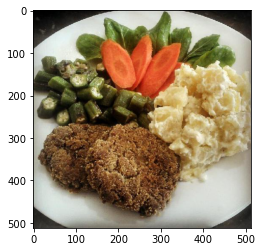

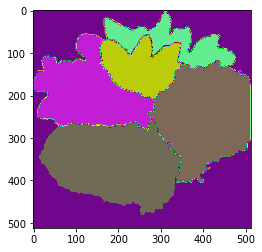

Ground truth Codes (array([ 0,  1, 28, 65, 74, 83], dtype=uint8), array([94793, 51990, 45770, 16081, 17986, 35524], dtype=int64))


In [18]:
### VISUALIZACAO DA MÁSCARA FICA COM A BORDA ESTRANHA, MAS ELA ESTÁ CORRETA COMO PODE SER VISTO NOS CODIGOS DO GROUND TRUTH

idx = 4
cmap = matplotlib.colors.ListedColormap(np.random.rand(256,3))

img = Image.open(fnames[idx])
arr = np.asarray(img)
plt.imshow(arr)
plt.show()

img1 = Image.open(get_y_fn(fnames[idx]))
arr = np.asarray(img1)
plt.imshow(arr, cmap=cmap, vmin=0, vmax=255)
plt.show()
print("Ground truth Codes",np.unique(arr,return_counts=True))


In [19]:
codes = np.loadtxt(path + 'classesNumber.txt', dtype=str, delimiter='\n',encoding='utf')
codes = [code.split(": ")[1] for code in codes] #pega apenas o nome de cada classe e ignora o ID
len(codes)

117

In [20]:
bs = 8 # batch size
print(sizeImage)

(512, 512)


## Data Augmentation

In [21]:
tfms = aug_transforms(pad_mode='zeros', mult=1, min_scale=1, flip_vert=True, size=sizeImage, max_warp=0.2)

## Dataloaders

In [22]:
dataloaders = SegmentationDataLoaders.from_label_func(path, bs=bs,
    fnames = fnames, 
    label_func = get_y_fn,                                     
    codes = codes,   
    valid_pct=0.3,
    seed=None,                
    batch_tfms=[*tfms, Normalize.from_stats(*imagenet_stats)])

dataloaders.vocab = codes


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [23]:
len(dataloaders.train_ds), len(dataloaders.valid_ds)

(356, 152)

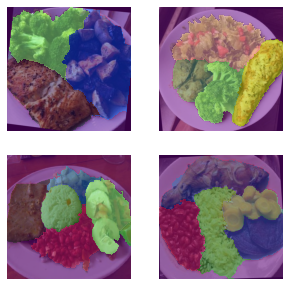

In [24]:
dataloaders.train.show_batch(max_n=4, figsize=(5, 5), cmap=cmap)

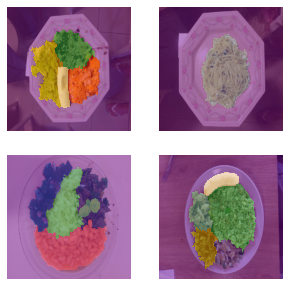

In [25]:
dataloaders.valid.show_batch(max_n=4, figsize=(5, 5), cmap=cmap)

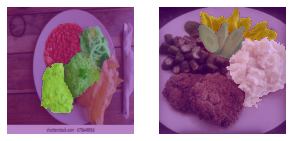

In [26]:
test_fnames = fnames[3:5]
test_dl = dataloaders.test_dl(test_fnames, with_labels=True)
test_dl.vocab = codes
test_dl.show_batch(max_n=4, figsize=(5, 5), cmap=cmap)

## Metrics

In [27]:
void_code = 0

def acc_segmentation(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

metrics = [acc_segmentation, DiceMulti]

## Model

In [22]:
modelCallbacks = [ShowGraphCallback,EarlyStoppingCallback(patience=20)]
learner = unet_learner(dataloaders, resnet34, loss_func=CrossEntropyLossFlat(axis=1), metrics=metrics, cbs=modelCallbacks,
                       wd_bn_bias=True).to_fp16()

C:\Users\bruno\miniconda3\lib\site-packages\torch\cuda\amp\autocast_mode.py:114: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


In [ ]:
learner.model[0].load_state_dict(torch.load(path + 'resnet34_encoder-food101.h5'), strict=True); #load preTrained from FOOD101

In [ ]:
# learner.load(path + 'stage-2-brazilFoods', strict=False)
# learner.load_state_dict(torch.load(path + 'stage-2-brazilFoods.pth'), strict=False)
# learner.model.load_state_dict(torch.load(path + 'stage-2-brazilFoods.pth'), strict=False)
# test = Learner(dataloaders,resnet34)
# test.model[0].

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


## Training

SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=0.0002290867705596611)

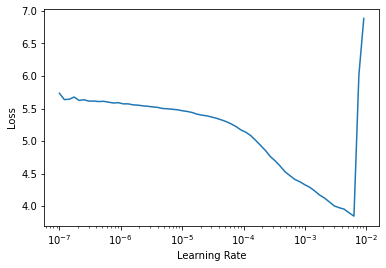

In [ ]:
learner.lr_find()

In [ ]:
lr = 2e-3
epochs = 100
wd = 1e-2
learner.freeze()

epoch,train_loss,valid_loss,acc_segmentation,dice_multi,time
0,2.663556,2.056118,0.029963,0.010966,00:54
1,2.080249,1.879988,0.123275,0.023801,00:54
2,1.852604,1.731992,0.173717,0.027493,00:54
3,1.689312,1.647740,0.205946,0.037054,00:54
4,1.588825,1.607725,0.230372,0.039275,00:54
5,1.497093,1.572136,0.228225,0.045162,00:54
6,1.442742,1.462104,0.289429,0.049714,00:54
7,1.390253,1.493640,0.284476,0.051604,00:54
8,1.324726,1.451540,0.305209,0.050941,00:54
9,1.304391,1.456521,0.297231,0.055705,00:54


Better model found at epoch 0 with acc_segmentation value: 0.029962699860334396.


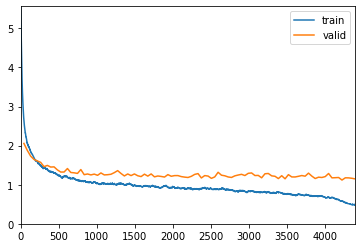

Better model found at epoch 1 with acc_segmentation value: 0.12327481806278229.
Better model found at epoch 2 with acc_segmentation value: 0.17371658980846405.
Better model found at epoch 3 with acc_segmentation value: 0.20594646036624908.
Better model found at epoch 4 with acc_segmentation value: 0.2303716242313385.
Better model found at epoch 6 with acc_segmentation value: 0.28942862153053284.
Better model found at epoch 8 with acc_segmentation value: 0.30520862340927124.
Better model found at epoch 10 with acc_segmentation value: 0.31493860483169556.
Better model found at epoch 11 with acc_segmentation value: 0.348404198884964.
Better model found at epoch 16 with acc_segmentation value: 0.36365997791290283.
Better model found at epoch 18 with acc_segmentation value: 0.37064841389656067.
Better model found at epoch 19 with acc_segmentation value: 0.3943151533603668.
Better model found at epoch 22 with acc_segmentation value: 0.4132751524448395.
Better model found at epoch 30 with acc

In [ ]:
wandb.init(project="diabetesLearning") # track machine learning experiment
fitCallbacks = [WandbCallback(log='all'), SaveModelCallback(every_epoch=False, monitor='acc_segmentation', fname='stage-1-best')]
learner.fit_one_cycle(epochs, slice(lr), pct_start=0.9, wd=wd, cbs=fitCallbacks)

## Fine-tunning

In [ ]:
# learner = unet_learner(dataloaders, resnet34, loss_func=CrossEntropyLossFlat(axis=1), metrics=metrics, cbs=callbacks,
#                        wd_bn_bias=True).to_fp16()
# learner.load('stage-1-best')


SuggestedLRs(lr_min=7.585775892948732e-06, lr_steep=7.585775847473997e-07)

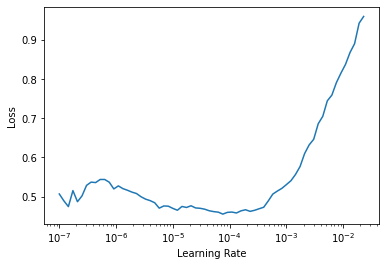

In [ ]:
learner.unfreeze()
learner.lr_find()

In [ ]:
lrs = slice(lr/400,lr/4)
epochs = 50
wd = 1e-2

epoch,train_loss,valid_loss,acc_segmentation,dice_multi,time
0,0.481865,1.149323,0.519992,0.182406,00:56
1,0.482287,1.150070,0.516132,0.180889,00:56
2,0.481119,1.153654,0.514409,0.179664,00:56
3,0.473385,1.134129,0.521226,0.182081,00:56
4,0.472098,1.143550,0.519575,0.181394,00:56
5,0.463759,1.163809,0.515896,0.179590,00:56
6,0.464253,1.163632,0.518373,0.179474,00:56
7,0.470399,1.149076,0.519838,0.183369,00:56
8,0.472201,1.160355,0.514526,0.182741,00:56
9,0.476535,1.158516,0.520991,0.181174,00:56


Better model found at epoch 0 with acc_segmentation value: 0.5199917554855347.


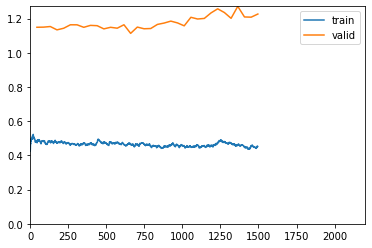

Better model found at epoch 3 with acc_segmentation value: 0.5212262272834778.
Better model found at epoch 10 with acc_segmentation value: 0.524182140827179.
Better model found at epoch 12 with acc_segmentation value: 0.5249100923538208.
Better model found at epoch 13 with acc_segmentation value: 0.5307233333587646.
Better model found at epoch 14 with acc_segmentation value: 0.5343295931816101.
Better model found at epoch 22 with acc_segmentation value: 0.5358467698097229.
No improvement since epoch 14: early stopping


In [ ]:
fitCallbacks = [WandbCallback(log='all'), SaveModelCallback(every_epoch=False, monitor='acc_segmentation', fname='stage-2-best')]
learner.fit_one_cycle(epochs, lrs, pct_start=0.8, wd=wd, cbs=fitCallbacks)

In [ ]:
# learner.load('stage-2-best')
# learner.save('stage-2-size350-bestEpoch')

## Validation

In [101]:
# LOAD ONLY IF NECESSARY
id2name = {k:v for k,v in enumerate(codes)} # faz uma lista que relaciona nome e id
learner = unet_learner(dataloaders, resnet34, metrics=metrics)
learner.load('stage-2-best')

C:\Users\bruno\miniconda3\lib\site-packages\fastai\learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [32]:
print(learner.validate(dl=test_dl))

[1.746864676475525, 0.26330190896987915, 0.17672905059279487]


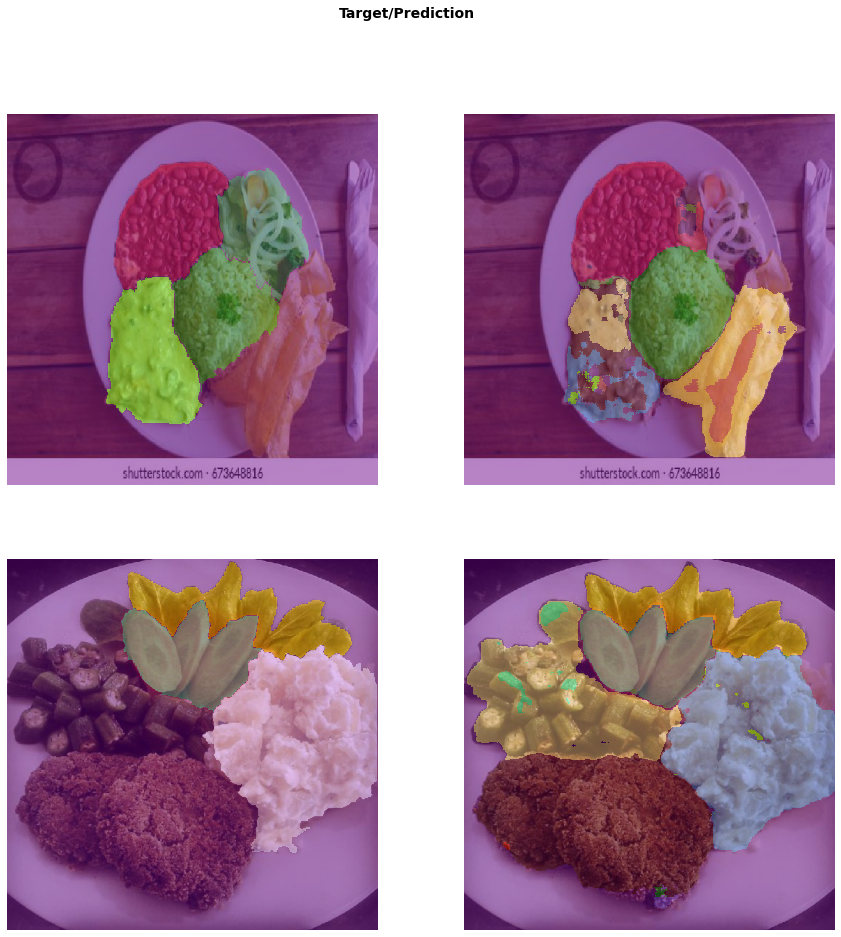

In [33]:
learner.show_results(dl=test_dl, figsize=(15,15), max_n=20, cmap=cmap)

In [34]:
interp = Interpretation.from_learner(learner, dl=test_dl)

In [78]:
losses,idxs = interp.top_losses()
interp.plot_top_losses(2, figsize=(15,11), cmap=cmap)

NameError: name 'interp' is not defined

In [31]:
#interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
#interp.most_confused(min_val=10)

In [102]:
input, probabilities, groundTruth, decoded, losses = learner.get_preds(dl=test_dl,  with_input=True, with_loss=True, with_decoded=True, act=F.softmax) #inputs, preds, groundTruth, losses

C:\Users\bruno\miniconda3\lib\site-packages\torch\tensor.py:995: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ret = func(*args, **kwargs)


<AxesSubplot:>

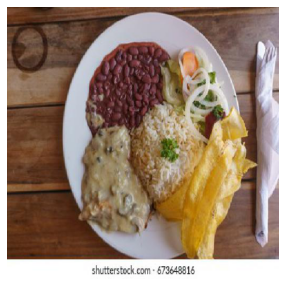

In [110]:
idx = 0

image = input[idx]
nrm = Normalize.from_stats(*imagenet_stats)
nrm.decode(image).clamp(0,1).squeeze().show() # denorm image from imagenet stats


In [151]:
def decodeClassAndPrint(tensor, removeVoid=False):
    foods, counts = np.unique(tensor,return_counts=True)
    if removeVoid:
        counts = np.delete(counts, 0) #tira o void na posicao 0 do array
        foods = np.delete(foods, 0) #tira o void na posicao 0 do array
    
    foodNames = []
    print(f'Numero de alimentos: {len(foods)}')
    for food in foods:
        foodNames = np.append(foodNames,id2name[food])
    dictCounts = dict(zip(foodNames, counts))
    print(dictCounts)
    return dictCounts

Numero de alimentos: 6
{'NaoAlimento': 169307, 'AlimentoNaoRegistrado': 22992, 'Arroz Branco': 17006, 'Feijão': 19310, 'Strogonoff': 19310, 'Cebola Crua': 14219}


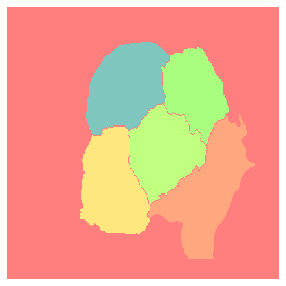

In [154]:
cmap = "prism"
#cmap = matplotlib.colors.ListedColormap(np.random.rand(256,3))
sample = groundTruth[idx]
sample.show(cmap=cmap)
gtDictCounts = decodeClassAndPrint(sample)


Numero de alimentos: 15
{'NaoAlimento': 183950, 'AlimentoNaoRegistrado': 16, 'Arroz Branco': 19162, 'Feijão': 20712, 'Arroz Branco e Feijao': 535, 'Pure de Batata': 4544, 'Mandioca': 4319, 'Inhame': 112, 'Banana': 21230, 'Abacaxi': 337, 'Pão Branco': 6597, 'Strogonoff': 396, 'Batata Frita': 76, 'Carne de Porco': 154, 'Presunto': 4}


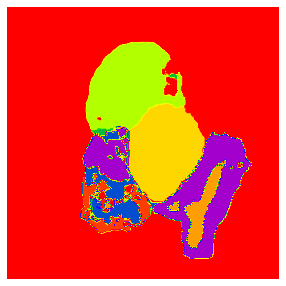

In [155]:
sample = decoded[idx]
sample.show(cmap=cmap)
decodedDictCounts = decodeClassAndPrint(sample)


In [167]:
# get low prob classes

bestProbs, bestProbsIdx = torch.max(probabilities[idx], dim=0)
lowProbs = []
lowProbsIdx = []

mask = bestProbs < 0.5
lowProbsIdx = bestProbsIdx[mask]
lowProbDictCounts = decodeClassAndPrint(lowProbsIdx)

print("\nPercentual de pixeis com baixa probabilidade\n")
for key, value in lowProbDictCounts.items():
    pct = float(value/decodedDictCounts[key]*100)
    print(key, '{:.2f}'.format(pct), "%" )

Numero de alimentos: 15
{'NaoAlimento': 5118, 'AlimentoNaoRegistrado': 16, 'Arroz Branco': 955, 'Feijão': 1711, 'Arroz Branco e Feijao': 509, 'Pure de Batata': 4544, 'Mandioca': 4319, 'Inhame': 112, 'Banana': 12089, 'Abacaxi': 337, 'Pão Branco': 5688, 'Strogonoff': 396, 'Batata Frita': 76, 'Carne de Porco': 154, 'Presunto': 4}

Percentual de pixeis com baixa probabilidade

NaoAlimento 2.78 %
AlimentoNaoRegistrado 100.00 %
Arroz Branco 4.98 %
Feijão 8.26 %
Arroz Branco e Feijao 95.14 %
Pure de Batata 100.00 %
Mandioca 100.00 %
Inhame 100.00 %
Banana 56.94 %
Abacaxi 100.00 %
Pão Branco 86.22 %
Strogonoff 100.00 %
Batata Frita 100.00 %
Carne de Porco 100.00 %
Presunto 100.00 %


In [168]:
# get high prob classes

bestProbs, bestProbsIdx = torch.max(probabilities[idx], dim=0)

mask = bestProbs > 0.5
highProbsIdx = bestProbsIdx[mask]
highProbDictCounts = decodeClassAndPrint(highProbsIdx)

print("\nPercentual de pixeis com alta probabilidade\n")
for key, value in highProbDictCounts.items():
    pct = float(value/decodedDictCounts[key]*100)
    print(key, '{:.2f}'.format(pct), "%" )

Numero de alimentos: 6
{'NaoAlimento': 178832, 'Arroz Branco': 18207, 'Feijão': 19001, 'Arroz Branco e Feijao': 26, 'Banana': 9141, 'Pão Branco': 909}

Percentual de pixeis com alta probabilidade

NaoAlimento 97.22 %
Arroz Branco 95.02 %
Feijão 91.74 %
Arroz Branco e Feijao 4.86 %
Banana 43.06 %
Pão Branco 13.78 %


## Predictions

C:\Users\bruno\miniconda3\lib\site-packages\fastai\metrics.py:376: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)


<AxesSubplot:>

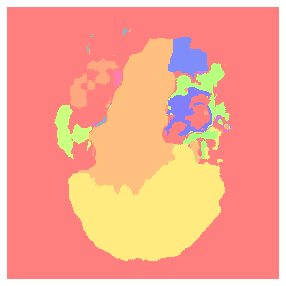

In [184]:
index = 2
pred = learner.predict(dataloaders.valid_ds[index][0])
pred[0].show(cmap=cmap)

<AxesSubplot:>

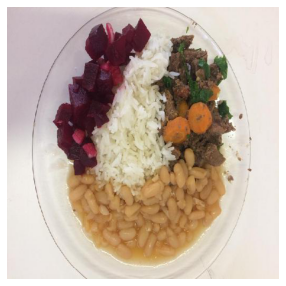

In [185]:
dataloaders.valid_ds[index][0].show()